# SVM+HOG

- Extract HOG features with tunable params
- Flatten features and scale with StandardScaler
- Use shallow MLP (1 hidden layer) with ReLU, Dropout, and Linear output (3 classes)
- Optimise MLP hyperparameters (hidden size, LR, dropout) and HOG params jointly with Optuna

In [3]:
#imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import joblib
import optuna
from pathlib import Path
from tqdm import tqdm
from skimage.feature import hog
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC as CPU_SVC
from sklearn.preprocessing import StandardScaler as CPU_StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')


In [22]:
# GPU/CPU Setup
try:
    import cupy as cp
    from cuml.svm import SVC as GPU_SVC
    from cuml.preprocessing import StandardScaler as GPU_StandardScaler
    has_gpu = True
    print("GPU acceleration available")
except ImportError:
    has_gpu = False
    print("GPU acceleration not available, using CPU only")
    cp = np
    GPU_SVC = CPU_SVC
    GPU_StandardScaler = CPU_StandardScaler


GPU acceleration available


In [4]:
# %%
#path Setup and K-fold Split Loading
projectRoot = Path().resolve().parent
datasetPath = projectRoot / "CV2024_CW_Dataset"
outputRoot = projectRoot / "ModifiedDataset"

trainImagePath = outputRoot / "train" / "images"
trainLabelPath = outputRoot / "train" / "labels"
testImagePath = outputRoot / "test" / "images"
testLabelPath = outputRoot / "test" / "labels"
augDataPath = outputRoot / "AugmentedData" / "images"
augLabelPath = outputRoot / "AugmentedData" / "labels"

modelsDir = projectRoot / "models"
modelsDir.mkdir(parents=True, exist_ok=True)

for path in [trainImagePath, trainLabelPath, testImagePath, testLabelPath, augDataPath, augLabelPath]:
    if not path.exists():
        print(f"Warning: Path {path} does not exist")

with open(outputRoot / "kfold_splits.json", "r") as f:
    kfold_splits = json.load(f)

print("Paths set up successfully. Found k-fold splits.")


Paths set up successfully. Found k-fold splits.


In [24]:
#helper Functions - HOG, loading, conversion
def compute_hog_features(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False):
    return hog(
        image,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=visualize,
        feature_vector=True
    )

def extract_hog_features(image_paths, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), cache_path=None):
    if cache_path and os.path.exists(cache_path):
        return joblib.load(cache_path)

    features = []
    for img_path in tqdm(image_paths, desc="Extracting HOG features"):
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Warning: Could not read image {img_path}")
            continue
        hog_features = compute_hog_features(image, orientations, pixels_per_cell, cells_per_block)
        features.append(hog_features)

    features = cp.array(features) if has_gpu else np.array(features)

    if cache_path:
        joblib.dump(features, cache_path)

    return features


def load_dataset(image_dir, label_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpeg')])
    image_paths, labels = [], []
    for fname in image_files:
        image_paths.append(os.path.join(image_dir, fname))
        with open(os.path.join(label_dir, fname.replace('.jpeg', '.txt')), 'r') as f:
            labels.append(int(f.read().strip()))
    return image_paths, cp.array(labels) if has_gpu else np.array(labels)

def to_numpy(arr):
    return cp.asnumpy(arr) if has_gpu and isinstance(arr, cp.ndarray) else arr


In [25]:
#load Datasets and Combine Labels
print("Loading datasets...")
train_image_paths, train_labels = load_dataset(trainImagePath, trainLabelPath)
test_image_paths, test_labels = load_dataset(testImagePath, testLabelPath)
aug_image_paths, aug_labels = load_dataset(augDataPath, augLabelPath)

train_labels_np = to_numpy(train_labels)
aug_labels_np = to_numpy(aug_labels)
all_train_image_paths = train_image_paths + aug_image_paths
all_train_labels = cp.concatenate([train_labels, aug_labels]) if has_gpu else np.concatenate([train_labels_np, aug_labels_np])
all_train_labels_np = np.concatenate([train_labels_np, aug_labels_np])

print(f"Loaded {len(train_image_paths)} training, {len(aug_image_paths)} augmented, {len(test_image_paths)} test images")
print(f"Class distribution: {np.bincount(all_train_labels_np)}")


Loading datasets...
Loaded 2394 training, 1454 augmented, 458 test images
Class distribution: [1128 1940  780]


In [26]:
#Class Weights
class_counts = np.bincount(all_train_labels_np)
n_samples = len(all_train_labels_np)
weight_dict = {i: n_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}
print(f"Calculated class weights: {weight_dict}")


Calculated class weights: {0: 1.1371158392434988, 1: 0.6611683848797251, 2: 1.6444444444444444}


In [27]:
#Subset for Optimization
def create_subset_for_optimization(image_paths, labels, sample_per_class=100):
    labels_np = to_numpy(labels)
    class_indices = {0: [], 1: [], 2: []}
    for i, label in enumerate(labels_np):
        class_indices[label].append(i)
    samples_per_class = min(sample_per_class, *(len(v) for v in class_indices.values()))
    subset_indices = [i for label, idxs in class_indices.items() for i in np.random.choice(idxs, samples_per_class, replace=False)]
    return [image_paths[i] for i in subset_indices], labels[subset_indices]

np.random.seed(42)
opt_image_paths, opt_labels = create_subset_for_optimization(all_train_image_paths, all_train_labels)
print(f"Optimization subset: {len(opt_image_paths)} samples. Class dist: {np.bincount(to_numpy(opt_labels))}")


Optimization subset: 300 samples. Class dist: [100 100 100]


In [28]:
#Optuna Optimization
def objective(trial):
    orientations = trial.suggest_int('orientations', 8, 14)
    ppc_size = trial.suggest_int('pixels_per_cell_size', 6, 12)
    cpb_size = trial.suggest_int('cells_per_block_size', 2, 4)

    hog_cache_path = f"/tmp/hog_cache_{orientations}_{ppc_size}_{cpb_size}.joblib"
    features = extract_hog_features(
        opt_image_paths,
        orientations,
        (ppc_size, ppc_size),
        (cpb_size, cpb_size),
        cache_path=hog_cache_path
    )

    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
    C = trial.suggest_float('C', 0.01, 300.0, log=True)

    gamma = 'scale'
    if kernel in ['rbf', 'poly', 'sigmoid']:
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)
    else:
        degree = 3  # default poly degree

    class_weight = 'balanced'

    try:
        clf = GPU_SVC(
            kernel=kernel,
            C=C,
            gamma=gamma,
            probability=False,  # disables probas = faster
            class_weight=class_weight,
            degree=degree
        ) if has_gpu else CPU_SVC(
            kernel=kernel,
            C=C,
            gamma=gamma,
            probability=False,
            class_weight=class_weight,
            degree=degree
        )

        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        accuracies = []

        for train_idx, val_idx in skf.split(to_numpy(features), to_numpy(opt_labels)):
            X_train, X_val = features[train_idx], features[val_idx]
            y_train, y_val = opt_labels[train_idx], opt_labels[val_idx]

            scaler = GPU_StandardScaler() if has_gpu else CPU_StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)

            acc = accuracy_score(to_numpy(y_val), to_numpy(y_pred))
            accuracies.append(acc)

        return np.mean(accuracies)

    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0


# Run Optuna study
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)
study.optimize(objective, n_trials=150, timeout=3600, show_progress_bar=True)

# Get the best hyperparameters from the study
best_params = study.best_params


[I 2025-04-20 19:04:46,974] A new study created in memory with name: no-name-b55ce134-3a36-44a5-aabc-8529acf913cc


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-04-20 19:04:48,657] Trial 0 finished with value: 0.6766666666666667 and parameters: {'orientations': 10, 'pixels_per_cell_size': 12, 'cells_per_block_size': 4, 'kernel': 'linear', 'C': 75.50498620956354}. Best is trial 0 with value: 0.6766666666666667.
[I 2025-04-20 19:04:53,786] Trial 1 finished with value: 0.73 and parameters: {'orientations': 12, 'pixels_per_cell_size': 10, 'cells_per_block_size': 2, 'kernel': 'linear', 'C': 0.06624059568209133}. Best is trial 1 with value: 0.73.
[I 2025-04-20 19:04:55,318] Trial 2 finished with value: 0.6066666666666666 and parameters: {'orientations': 10, 'pixels_per_cell_size': 9, 'cells_per_block_size': 3, 'kernel': 'rbf', 'C': 0.43676355831098146, 'gamma': 'auto'}. Best is trial 1 with value: 0.73.
[I 2025-04-20 19:04:56,955] Trial 3 finished with value: 0.6933333333333334 and parameters: {'orientations': 9, 'pixels_per_cell_size': 9, 'cells_per_block_size': 3, 'kernel': 'rbf', 'C': 177.1232641685744, 'gamma': 'scale'}. Best is trial 1 

In [29]:
# extract Features with best params
best_orientations = best_params['orientations']
best_pixels_per_cell = (best_params['pixels_per_cell_size'], best_params['pixels_per_cell_size'])
best_cells_per_block = (best_params['cells_per_block_size'], best_params['cells_per_block_size'])
best_kernel = best_params['kernel']
best_C = best_params['C']
best_gamma = best_params.get('gamma', 'scale')  # May not be in best_params if kernel is 'linear'
best_class_weight = 'balanced'  # Fixed to always use balanced

# extract HOG features for all training images
X_train_full = extract_hog_features(
    all_train_image_paths,
    best_orientations,
    best_pixels_per_cell,
    best_cells_per_block
)

# save the best HOG config
joblib.dump({
    'orientations': best_orientations,
    'pixels_per_cell': best_pixels_per_cell,
    'cells_per_block': best_cells_per_block
}, os.path.join(modelsDir, "best_hog_params.joblib"))

# convert to NumPy
X_train_full_np = to_numpy(X_train_full)
all_train_labels_np = to_numpy(all_train_labels)


Extracting HOG features: 100%|█████████████████████████████████████████████████████| 3848/3848 [00:20<00:00, 192.39it/s]


In [30]:
print("\n########## Best Parameters Found by Optuna ##########")
for k, v in best_params.items():
    print(f"{k}: {v}")

print("\nHOG Settings:")
print(f"  orientations: {best_orientations}")
print(f"  pixels_per_cell: {best_pixels_per_cell}")
print(f"  cells_per_block: {best_cells_per_block}")



########## Best Parameters Found by Optuna ##########
orientations: 13
pixels_per_cell_size: 10
cells_per_block_size: 3
kernel: linear
C: 0.07463130721035442

HOG Settings:
  orientations: 13
  pixels_per_cell: (10, 10)
  cells_per_block: (3, 3)


Fold 0 Accuracy: 0.7870
Fold 1 Accuracy: 0.7506
Fold 2 Accuracy: 0.7455
Fold 3 Accuracy: 0.7958
Fold 4 Accuracy: 0.7802

Overall Accuracy: 0.7718
               precision    recall  f1-score   support

      No Mask       0.67      0.72      0.70      1128
         Mask       0.85      0.84      0.84      1940
Improper Mask       0.73      0.69      0.71       780

     accuracy                           0.77      3848
    macro avg       0.75      0.75      0.75      3848
 weighted avg       0.77      0.77      0.77      3848



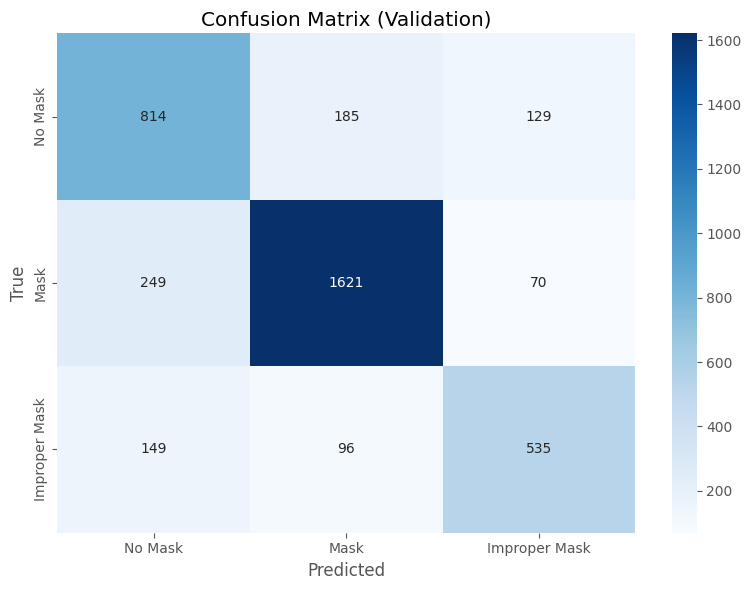

In [31]:
#K-Fold Evaluation
fold_metrics = []
all_predictions, all_true_labels = [], []

for fold_idx in kfold_splits:
    train_idx = kfold_splits[fold_idx]['train']
    val_idx = kfold_splits[fold_idx]['val']
    
    X_fold_train = X_train_full_np[train_idx]
    y_fold_train = all_train_labels_np[train_idx]
    X_fold_val = X_train_full_np[val_idx]
    y_fold_val = all_train_labels_np[val_idx]
    
    scaler = CPU_StandardScaler()
    X_fold_train = scaler.fit_transform(X_fold_train)
    X_fold_val = scaler.transform(X_fold_val)
    
    clf = CPU_SVC(kernel=best_kernel, C=best_C, gamma=best_gamma, probability=True, class_weight=best_class_weight)
    clf.fit(X_fold_train, y_fold_train)
    y_pred = clf.predict(X_fold_val)
    
    fold_metrics.append({'fold': fold_idx, 'accuracy': accuracy_score(y_fold_val, y_pred)})
    all_predictions.extend(y_pred)
    all_true_labels.extend(y_fold_val)
    print(f"Fold {fold_idx} Accuracy: {fold_metrics[-1]['accuracy']:.4f}")

overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
print(classification_report(all_true_labels, all_predictions, target_names=['No Mask', 'Mask', 'Improper Mask']))

cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Mask', 'Mask', 'Improper Mask'],
            yticklabels=['No Mask', 'Mask', 'Improper Mask'])
plt.title('Confusion Matrix (Validation)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


Training final model...


Extracting HOG features: 100%|███████████████████████████████████████████████████████| 458/458 [00:02<00:00, 193.52it/s]


Test Accuracy: 0.7533
               precision    recall  f1-score   support

      No Mask       0.32      0.53      0.40        51
         Mask       0.91      0.80      0.85       388
Improper Mask       0.23      0.42      0.30        19

     accuracy                           0.75       458
    macro avg       0.49      0.58      0.52       458
 weighted avg       0.82      0.75      0.78       458



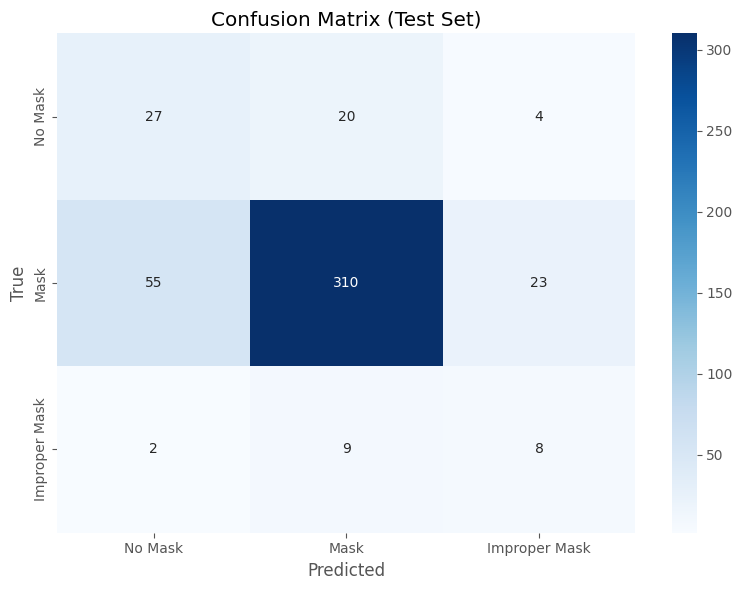


############ SUMMARY ############
Best kernel: linear
C: 0.07463130721035442
Gamma: scale
HOG: orientations=13, pixels_per_cell=(10, 10), cells_per_block=(3, 3)
Validation Accuracy: 0.7718
Test Accuracy: 0.7533


In [32]:
#final model training and test evaluation
print("Training final model...")
scaler = CPU_StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full_np)
final_svm = CPU_SVC(kernel=best_kernel, C=best_C, gamma=best_gamma, probability=True, class_weight=best_class_weight)
final_svm.fit(X_train_full_scaled, all_train_labels_np)

joblib.dump(final_svm, os.path.join(modelsDir, "svm_hog_model.joblib"))
joblib.dump(scaler, os.path.join(modelsDir, "svm_hog_scaler.joblib"))

X_test = extract_hog_features(test_image_paths, best_orientations, best_pixels_per_cell, best_cells_per_block)
X_test_scaled = scaler.transform(to_numpy(X_test))
test_labels_np = to_numpy(test_labels)

test_preds = final_svm.predict(X_test_scaled)
print(f"Test Accuracy: {accuracy_score(test_labels_np, test_preds):.4f}")
print(classification_report(test_labels_np, test_preds, target_names=['No Mask', 'Mask', 'Improper Mask']))

test_cm = confusion_matrix(test_labels_np, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Mask', 'Mask', 'Improper Mask'],
            yticklabels=['No Mask', 'Mask', 'Improper Mask'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

print("\n############ SUMMARY ############")
print(f"Best kernel: {best_kernel}")
print(f"C: {best_C}")
print(f"Gamma: {best_gamma}")
print(f"HOG: orientations={best_orientations}, pixels_per_cell={best_pixels_per_cell}, cells_per_block={best_cells_per_block}")
print(f"Validation Accuracy: {overall_accuracy:.4f}")
print(f"Test Accuracy: {accuracy_score(test_labels_np, test_preds):.4f}")

